# <div align="center"><b> APSERa Simulation Pipeline for Cross Orthogonal Polarization </b></div>


## <div align="center"><b>  Modified Code With Dual Polarized Antenna </b></div>

In [1]:
frequencies = np.linspace(2,4,100) * u.GHz
print (frequencies)

NameError: name 'np' is not defined

### Trial 1 of plotting antenna patterns

In [ ]:
def gaussian_beam(theta, beam_width):
    return np.exp(-0.5 * (theta / np.radians(beam_width)) ** 2)

# Antenna parameters
beam_width_Azimuth = 30  # Beam width for antenna A (in azimuth) in degrees
beam_width_Elevation = 20  # Beam width for antenna A (in elevation) in degrees

beam_width_Azimuth_B = 20  # Beam width for antenna B (in azimuth) in degrees
beam_width_Elevation_B = 30  # Beam width for antenna B (in elevation) in degrees

# Theta values for calculating beam patterns
theta_range = np.linspace(-np.pi, np.pi, 1000)  # Range of angles from -pi to pi

# Calculate beam patterns for antenna A
beam_pattern_Azimuth = gaussian_beam(theta_range, beam_width_Azimuth)
#print(beam_pattern_Azimuth)
beam_pattern_Elevation = gaussian_beam(theta_range, beam_width_Elevation)

# Calculate beam patterns for antenna B
beam_pattern_Azimuth_B = gaussian_beam(theta_range, beam_width_Azimuth_B)
beam_pattern_Elevation_B = gaussian_beam(theta_range, beam_width_Elevation_B)


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.degrees(theta_range), beam_pattern_Azimuth, label='Azimuth')
plt.plot(np.degrees(theta_range), beam_pattern_Elevation, label='Elevation')
plt.xlabel('Angle (degrees)')
plt.ylabel('Beam Pattern')
plt.title('Antenna A Beam Patterns')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot beam patterns for antenna B
plt.figure(figsize=(10, 6))
plt.plot(np.degrees(theta_range), beam_pattern_Azimuth_B, label='Azimuth')
plt.plot(np.degrees(theta_range), beam_pattern_Elevation_B, label='Elevation')
plt.xlabel('Angle (degrees)')
plt.ylabel('Beam Pattern')
plt.title('Antenna B Beam Patterns')
plt.legend()
plt.grid()
plt.show()

# <div align = 'center'><b>Main Script</b></div>

### Task 1.1: Generating a PySM Sky Model

In [ ]:
pip install pysm

In [ ]:
pip install ephem

In [ ]:
pip install camb

In [2]:
# For computation and mathematics
import numpy as np
import math
import ephem
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator

#For working with sky coordinates and similar such arrangements
import healpy as hp

#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

#For generating sky model
import pysm3
import pysm3.units as u
from pysm3 import CMBMap

#Astronomical conversions
from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

#For working with data sets
import pandas as pd

#For CMB emission
import camb
from camb import model, initialpower

In [3]:
sky = pysm3.Sky(nside=16, preset_strings=["d1", "s1", "f1", "c1"])
#sky = pysm3.Sky(nside=1024, preset_strings=["s1"])

In [4]:
sky.components  #checking the components of sky

In [5]:
# frequencies = np.linspace(2,4,100)*u.GHz
# freq = (2.88)*u.GHz
# #print(freq)
# print(type(frequencies))

In [6]:
# extracting the frequencies from a csv file

pd.set_option('display.float_format', '{:.9f}'.format)   #setting the precision ofthe data taken
df = pd.read_csv("/home/pratush/APSERa_new/APSERa/APSERa_S11_Simulation.csv", dtype={'column_name': float}, index_col = None) #importing csv file
frequencies = df["Frequency"].values
frequencies = frequencies
freqs = frequencies*u.GHz
print(frequencies.shape)
print(frequencies)

(1001,)
[2.         2.00200009 2.00399995 ... 3.99600005 3.99799991 4.        ]


In [7]:
#calculating impedance based on S11 data obtained

S11 = df["S11"].values
print(type(S11))
Impedance = (50*(1+S11))/(1-S11)
print(Impedance.shape)

<class 'numpy.ndarray'>
(1001,)


In [8]:
#extracting sky emissions for multiple frequencies

polarized_maps = [] 

for m in freqs:
    sky_maps = sky.get_emission(m, weights=None)
    sky_maps = sky_maps/1e6
    polarized_maps.append(sky_maps)
    #print(sky_maps)

In [9]:
polarized_maps = np.array(polarized_maps)
print(type(polarized_maps))
print(polarized_maps.shape)
print(polarized_maps[:,2,:])

<class 'numpy.ndarray'>
(1001, 3, 3072)
[[-0.0058689   0.00894396 -0.00498329 ...  0.00184358  0.00235719
  -0.00700773]
 [-0.00585127  0.00891711 -0.0049683  ...  0.00183803  0.00235014
  -0.00698658]
 [-0.00583371  0.00889036 -0.00495338 ...  0.0018325   0.00234312
  -0.00696552]
 ...
 [-0.00073062  0.00111469 -0.00061906 ...  0.0002285   0.00029643
  -0.00086426]
 [-0.00072952  0.00111301 -0.00061813 ...  0.00022816  0.00029599
  -0.00086296]
 [-0.00072842  0.00111134 -0.0006172  ...  0.00022781  0.00029554
  -0.00086165]]


(3, 3072)


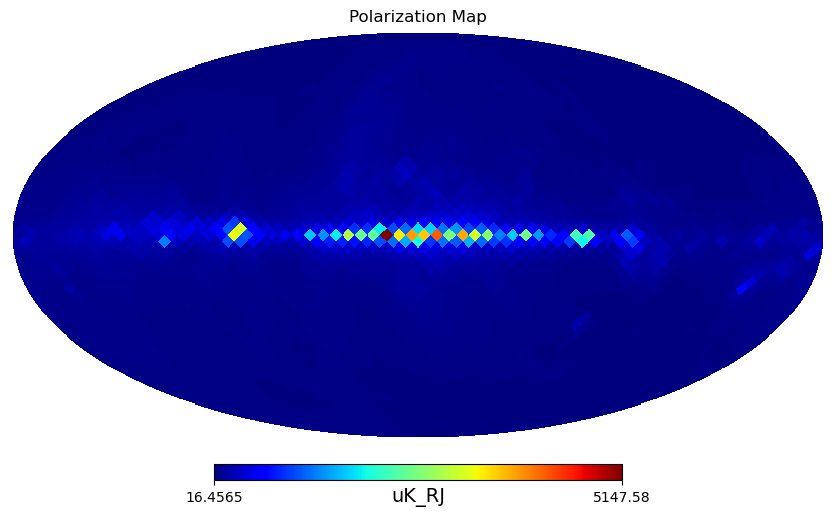

In [10]:
#combinig the maps for visualization

combined = np.sum(polarized_maps, axis = 0)
print(combined.shape)
hp.mollview(combined[0,:], title='Polarization Map', cmap='jet', unit='uK_RJ')

### Task 2: Replace beam with analytical beam

In [11]:
#Getting time and number of spectra

from datetime import datetime   # importing datetime module

start_time_in_UTC = str(datetime.now())
#print(start_time_in_UTC)

n_spectra = 1              #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2023-09-22 16:52:57.616']


In [12]:
#Defining Antenna Beam

#Beam fucntion for Antenna 1
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def_A1(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return ((math.sin(alt*np.pi/180))**2)*(math.sin(az*np.pi/180))

In [13]:
#Beam fucntion for Antenna 2
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def_A2(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return ((math.sin(alt*np.pi/180))**2)*(math.cos(az*np.pi/180))

In [14]:
#Basic Definitions

h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2                  #Check the f_start and f_stop and change the number of channels accordingly
f_stop = 4
No_of_Channels = 1001          # no.of frequency channels i.e. number of frequencies into consideration
Channel_width = 0.01
nside = 16
T_hot = 3730
T_cold = 2730                    #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 13.067439
longitude =80.237617            #Latitude and longitude in degrees
altitude = 0                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter) dry adiabatic lapse rate" (DALR), and it describes how the temperature of dry air changes with altitude as it rises in the Earth's atmosphere.
PI = 3.14159265
Noise_int_time = 3e+13
Trx = 14
T_atm = 1
num_components = 3                #no. of components in the sky emission i.e. I, Q & U
#freqs = np.linspace(f_start,f_stop, No_of_Channels)
#CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)


Voltage_Real = [0]*No_of_Channels 
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = np.zeros(No_of_Channels)
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra

cross_real_Q = [0]*No_of_Channels
cross_imag_Q = [0]*No_of_Channels
sumwt_Q = [0]*No_of_Channels
sigma_Q = np.zeros(No_of_Channels)
spectra_Q = [0]*n_spectra
spectra_cross_imag_Q = [0]*n_spectra


cross_real_U = [0]*No_of_Channels
cross_imag_U = [0]*No_of_Channels
sumwt_U = [0]*No_of_Channels
sigma_U = np.zeros(No_of_Channels)
spectra_U = [0]*n_spectra
spectra_cross_imag_U = [0]*n_spectra


#Power2 = [0]*No_of_Channels
Voltage_Real_A2 = [0]*No_of_Channels
cross_real2 = [0]*No_of_Channels
cross_imag2 = np.zeros(No_of_Channels)
sumwt2 = [0]*No_of_Channels
sigma2 = np.zeros(No_of_Channels)
spectra2 = [0]*n_spectra
spectra_cross_imag2 = [0]*n_spectra

cross_real3 = [0]*No_of_Channels
cross_imag3 = np.zeros(No_of_Channels)
sumwt3 = [0]*No_of_Channels
sigma3 = np.zeros(No_of_Channels)
spectra3 = [0]*n_spectra
spectra_cross_imag3 = [0]*n_spectra

cross_real4 = [0]*No_of_Channels
cross_imag4 = np.zeros(No_of_Channels)
sumwt4 = [0]*No_of_Channels
sigma4 = np.zeros(No_of_Channels)
spectra4 = [0]*n_spectra
spectra_cross_imag4 = [0]*n_spectra

npix = hp.nside2npix(nside)

In [15]:
#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)   #Simplified Barometric formula
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))  #This formula is used in the U. S. Naval Observatory's Vector Astrometry Software
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)             #converting from arcminutes to degrees
    return alt_in_deg +R

In [16]:
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

print(beam_def_A1(3.7,71.9,279.7))
print(beam_def_A2(2.8,70,30))

#plt.xlabel('Altitutde')
#plt.ylabel('Gain')
#plt.plot(theta_array_new[1:180],beam_3D_flip[50,1:180,0])



[22h19m05.1256707s]
-0.8905635240930115
0.7647196759766884


In [17]:
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix), nest=True)    #finding theta and phi value for each pixel in healpix map
print (npix,theta, phi)
#plt.plot(theta,npix)
#plt.plot(phi,npix)

3072 [1.52911759 1.48736624 1.48736624 ... 1.65422641 1.65422641 1.61247506] [0.78539816 0.83448555 0.73631078 ... 5.54687453 5.44869976 5.49778714]


In [18]:
#P_hot and P_cold for calibration
P_hot = (2*h*frequencies*1e9)/(np.exp((h*frequencies*1e9)/(k*T_hot))-1)
P_cold = (2*h*frequencies*1e9)/(np.exp((h*frequencies*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold

/tmp/ipykernel_385807/77857850.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(recomb_file,sep= "    " ,header = None)


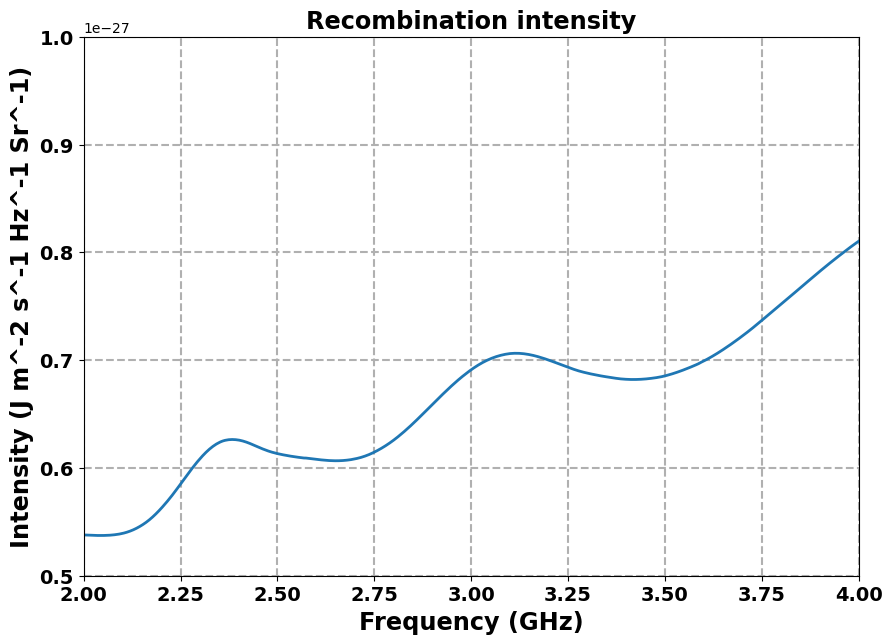

In [19]:
#Getting recombination lines

import os

recomb_path = "/home/pratush/APSERa_new/APSERa/APSERa_Files"
recomb_file = os.path.join(recomb_path,'total_spec_new.txt')
df = pd.read_csv(recomb_file,sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.figure(figsize=(10, 7))
plt.plot((df['Frequency']), (df['Intensity']),linewidth=2)
plt.title('Recombination intensity', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(frequencies)


## Task 3: Getting Spectra

### Task 3.1.1: Getting CMB Intensity

In [20]:
num_components = 3  # Number of Stokes parameters (I, Q, U)

# Initialize CAMB parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(3 * nside - 1, lens_potential_accuracy=0)

# Initialize the CAMB results object
results = camb.get_results(pars)

# Initialize an array to store CMB maps with the same shape as polarized_maps
cmb_maps = np.empty([No_of_Channels, num_components, npix])

# Generate CMB maps for each frequency and Stokes parameter
for i, freq_GHz in enumerate(frequencies):
    # Calculate CMB power spectra for the frequency
    powers = results.get_cmb_power_spectra(pars)
    
    # Loop through each Stokes parameter
    for j in range(num_components):
        cmb_power = powers['total'][2:3 * nside, j]  # Power spectrum for the component
        
        # Generate CMB map for the frequency and Stokes parameter
        cmb_maps[i, j] = hp.synfast(cmb_power, nside, new=True, verbose=False, fwhm=0)

# Now cmb_maps contains the CMB maps with the same shape as polarized_maps

cmb_temp = cmb_maps + TCMB # Correcting for CMB fluctuations

/tmp/ipykernel_385807/2711829301.py:25: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_maps[i, j] = hp.synfast(cmb_power, nside, new=True, verbose=False, fwhm=0)


[[2.72544905 2.72542181 2.72523318 ... 2.72542577 2.72565881 2.72541195]
 [2.72531828 2.72561639 2.72557096 ... 2.72532938 2.72557358 2.72532384]
 [2.7256456  2.72547512 2.72541615 ... 2.72557033 2.72537851 2.72573772]
 ...
 [2.72560529 2.72589822 2.72561893 ... 2.72530009 2.72558176 2.72535567]
 [2.72543092 2.72546709 2.7251997  ... 2.72555584 2.7255486  2.7252592 ]
 [2.72538353 2.72562597 2.72551882 ... 2.725484   2.72554934 2.72532798]]


<Figure size 640x480 with 0 Axes>

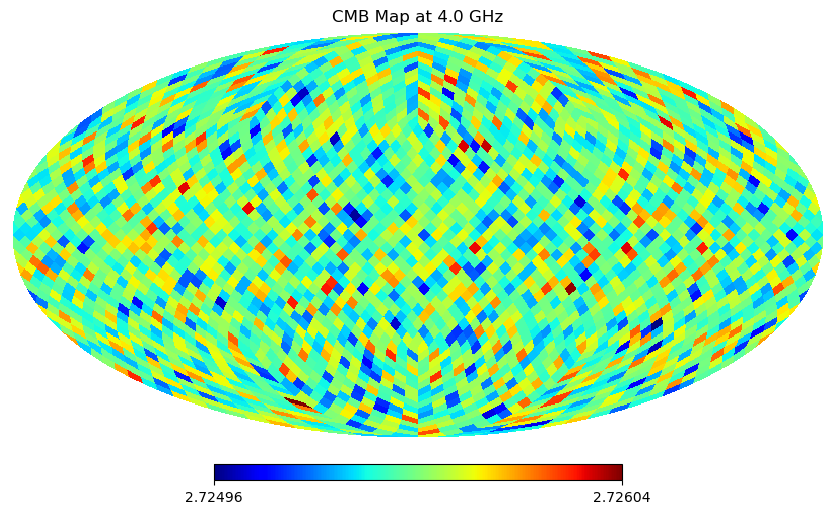

In [21]:
print(cmb_temp[:,0,:])        #checking shape of CMB map
plt.figure()
hp.mollview(cmb_temp[4,0,:], title=f"CMB Map at {freq_GHz} GHz", cmap="jet")

### Task 3.2: Spectra for Antenna 1

In [22]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power = (maps + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2)) * cwt
#                 print('Power:', Power)
                
                Voltage_Real[j] = Voltage_Real[j] + np.sqrt(2 * Power * Impedance[j])  # Voltage calculation for Antenna 1 with S11 values
#                 print('Voltage_Real', Voltage_Real)
                
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real[j] = cross_real[j] + final_temp
#                 print('Cross_real:',cross_real)
                
                sumwt[j] = sumwt[j]+ cwt
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        

    sigma = (np.array(cross_real) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real = cross_real + array * sigma
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag = cross_imag + array *  sigma 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra[t] = cross_real
#     print('spectra:', spectra[t])
    
    spectra_cross_imag[t] = cross_imag
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
    
#     print('Sigma:', sigma.shape, sigma)
#     print('array:', array.shape, array)
#     print('cross_real:', cross_real.shape, cross_real)
#     print('cross_img:', cross_img.shape, cross_imag)
#     print('spectra:', spectra.shape, spectra)
#     print('spectra_cross_imag', spectra_cross_imag.shape, spectra_cross_imag)

        
    t += 1 
    
    
    
#     print('Cross_real:', cross_real_spectra)
#     print('Cross_img:', cross_img)
#     print('spectra:', Spectra)
#     print("Shape of cross_real_spectra:", cross_real_spectra.shape)

Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
No. of spectra got =  1


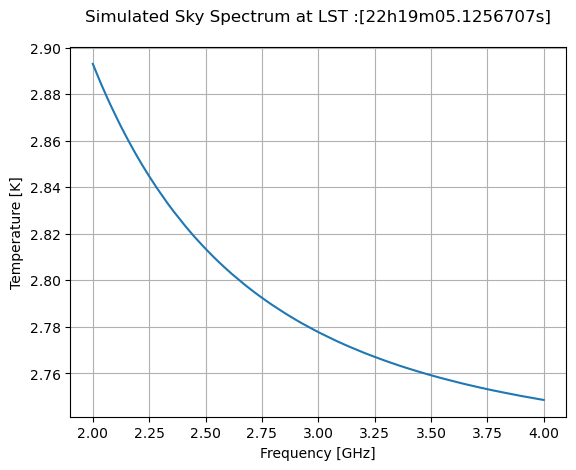

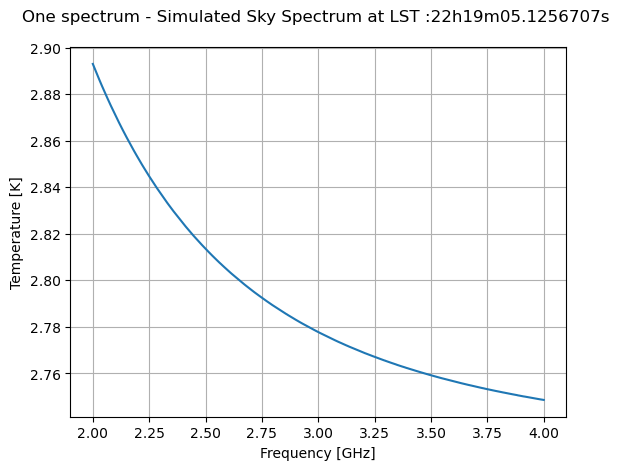

In [23]:
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

In [24]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        
        j = 0
        longitudes = equi.az.value
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt2 = beam_def_A2(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            
            if (cwt2>0):     #Adding all the three intensities

                maps2 = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)
                #print(maps)
                
                cmb_intensity2 = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                
                Power2 = (maps2 + cmb_intensity2 + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2)) * cwt2
                #print(Power2)
                
                Voltage_Real_A2[j] = Voltage_Real_A2[j] + np.sqrt(2 * Power2 * Impedance[j])  # Volate calculation for Antenna 1 with S11 values
                #print(Voltage_Real)
                
                final_temp2 = (Power2/P_dif[j])*(T_hot-T_cold)
                #print(type(final_temp))
                
                cross_real2[j] = cross_real2[j] + final_temp2
                #print(cross_real[j])
                
                sumwt2[j] = sumwt2[j]+ cwt2
                #print(sumwt[j])
                        
            j += 1
            
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i += 1
        
    i = 0
    while(i< No_of_Channels):
        if sumwt2[i]>0:
            cross_real2[i] = cross_real2[i]/sumwt2[i]
        i = i+1

    sigma2 = (np.array(cross_real2) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print(type(sigma))


    #Generating an array of random integers with mean 0 and std 1. 
    array2 = np.random.normal(0, 1, No_of_Channels)

    #Adding the gaussian error


    cross_real2 = cross_real2 + array2 * sigma2
    print(cross_real2)
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag2 = cross_imag2 + array2 * sigma2

    spectra2[t] = cross_real2
    spectra_cross_imag2[t] = cross_imag2

    cross_real2 = [0]*No_of_Channels
    cross_imag2 = [0]*No_of_Channels
    sumwt2 = [0]*No_of_Channels
    sigma2 = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)


    t += 1 


Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
[3.28625885 3.2847266  3.2832093  ... 2.81391908 2.81380425 2.81367957]
No. of spectra got =  1


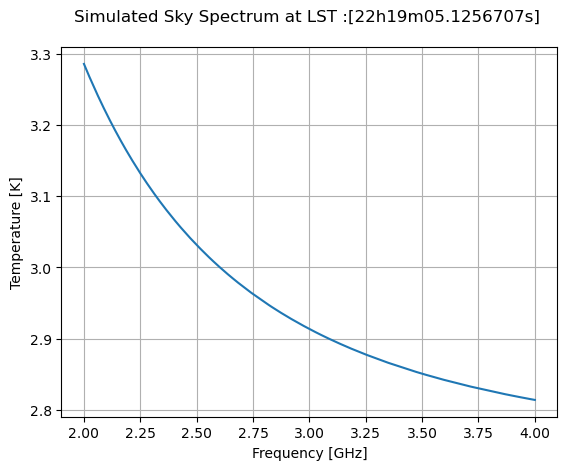

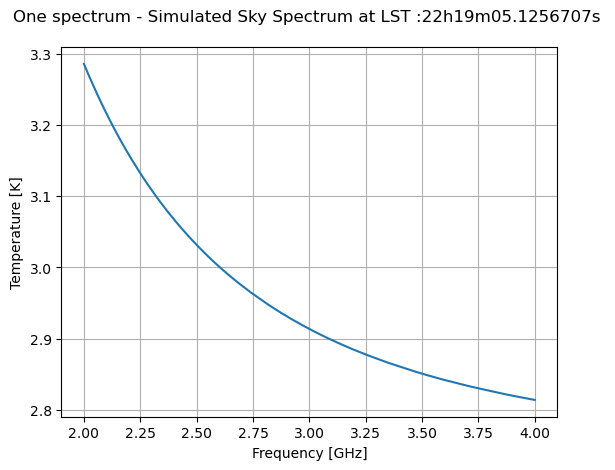

In [25]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra2[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(frequencies, spectra2[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

### Task 3.3 Finding Stokes parameters from both the antenna spectras

#### Task 3.3.1 Calculating Electric Field for Antenna 1 from Obtained Voltage Information

In [26]:
Voltage_Real = np.array(Voltage_Real)

In [27]:
len_eff = []       # finding effective length of the antenna based on frequencies
wavelength = [] 
for f in frequencies:
    wl = c / f * 1e+9
    wavelength.append(wl)
    length = c / (2 * f * 1e+9)
    len_eff.append(length)
len_eff = np.array(len_eff)

In [28]:
Ele_field_1 = []  #Finding electric field for antenna 1
for i in range(len(len_eff)):
    E = Voltage_Real[i] / len_eff[i] 
    Ele_field_1.append(E)

#### Task 3.3.2 Calculating Electric Field for Antenna 2 from obtained voltage information

In [29]:
Voltage_A2 = np.array(Voltage_Real_A2)

In [30]:
len_eff_2 = []       # finding effective length of the antenna 2 based on frequencies
wavelength2 = [] 
for f in frequencies:
    wl2 = c / f * 1e+9
    wavelength2.append(wl2)
    length2 = c / (2 * f * 1e+9)
    len_eff_2.append(length2)
len_eff_2 = np.array(len_eff_2)

In [31]:
Ele_field_2 = []  #Finding electric field for antenna 1
for i in range(len(len_eff_2)):
    E2 = Voltage_Real_A2[i] / len_eff_2[i] 
    Ele_field_2.append(E2)

In [32]:
Ele_field_1 = np.array(Ele_field_1) 
Ele_field_2 = np.array(Ele_field_2) 

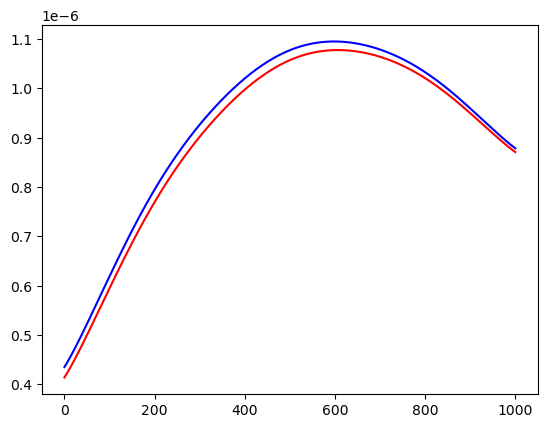

In [33]:
plt.plot(Ele_field_1, 'r')
plt.plot(Ele_field_2, 'b')

#### Task 3.3.3. Computing I, Q, U, V based on electric fields

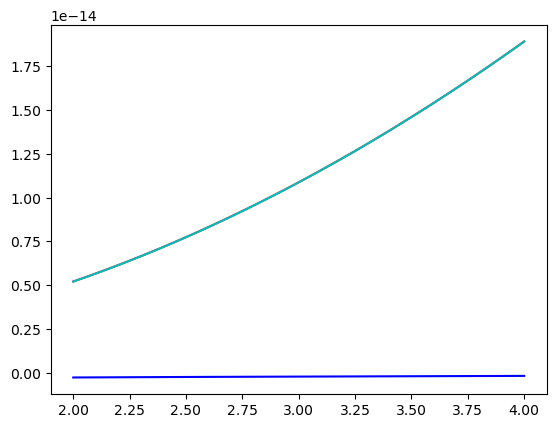

In [34]:
I = (((Ele_field_1**2)/Impedance) + ((Ele_field_2**2)/Impedance))
Q = (((Ele_field_1**2)/Impedance) - ((Ele_field_2**2)/Impedance))
U = (2*Ele_field_1*Ele_field_2)/Impedance
V = [0]*No_of_Channels                                                                                         

plt.plot(frequencies, I, 'r')
plt.plot(frequencies, Q, 'b')
plt.plot(frequencies, U, 'c')

In [35]:
#Making a 2D matrix of I, Q, U and V

I = np.array(I)
Q = np.array(Q)
U = np.array(U)
V = np.array(V)

Sky_Pol = np.stack((I, Q, U, V))

In [36]:
identity = np.identity(4) # Muellur Matrix for the antenna

In [37]:
#Carrying out matrix multiplication to compute Final Stokes parameters

Final_Pol = np.zeros((4,1001))
for i in range(len(identity)):
   # iterate through columns of Y
   for j in range(len(Sky_Pol[0])):
       # iterate through rows of Y
       for k in range(len(Sky_Pol)):
           Final_Pol[i][j] += identity[i][k] * Sky_Pol[k][j]

for r in Final_Pol:
   print(r)

[5.21477588e-15 5.22365908e-15 5.23255881e-15 ... 1.88628809e-14
 1.88812449e-14 1.88996153e-14]
[-2.57651530e-16 -2.57514168e-16 -2.57379203e-16 ... -1.67045115e-16
 -1.67017618e-16 -1.66920869e-16]
[5.20840697e-15 5.21730780e-15 5.22622499e-15 ... 1.88621412e-14
 1.88805062e-14 1.88988781e-14]
[0. 0. 0. ... 0. 0. 0.]


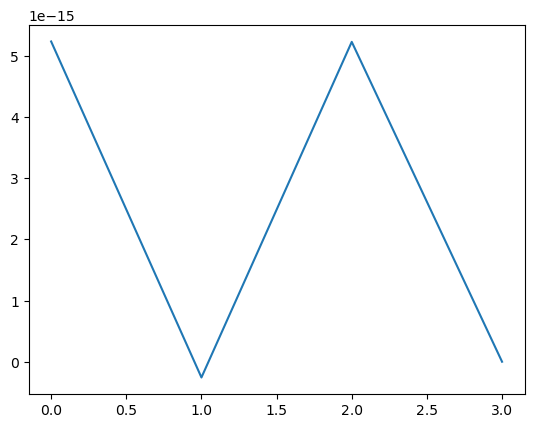

In [38]:
plt.plot(Final_Pol[:,2])

In [39]:
#Extracting individual I, Q, U, V

I_dash = Final_Pol[0,:]
Q_dash = Final_Pol[1,:]
U_dash = Final_Pol[2,:]
V_dash = Final_Pol[3,:]

#### 3.3.4. Computing the I Spectra

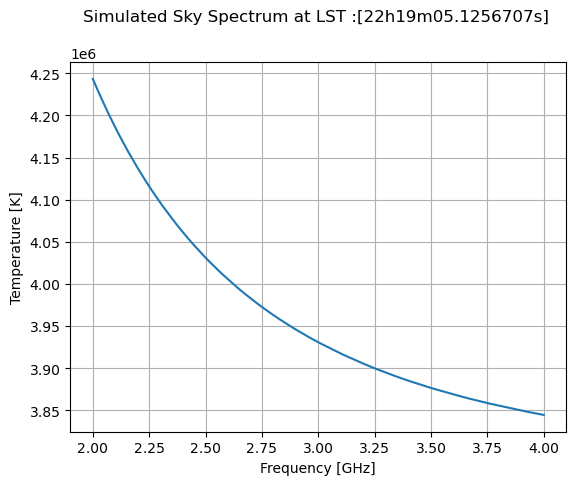

In [40]:
Power_I = I_dash * (c**2 / (1e+18 * frequencies**2))
Stokes_I = (Power_I/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_I)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

#### 3.3.4. Computing the Q Spectra

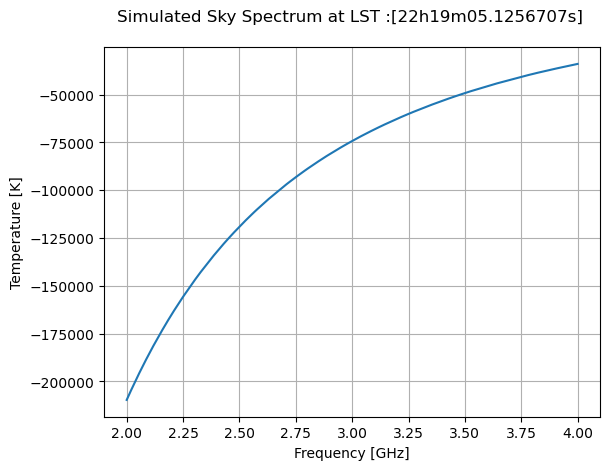

In [41]:
Power_Q = Q_dash * (c**2 / (1e+18 * frequencies**2))
Stokes_Q = (Power_Q/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_Q)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()


#### 3.3.5 Computing  the U spectra

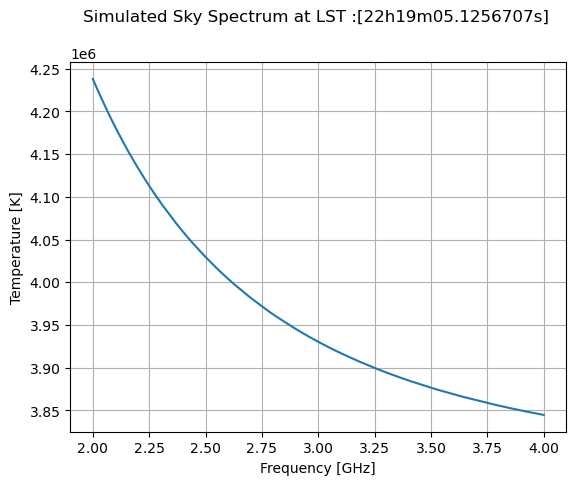

In [42]:
Power_U = U_dash * (c**2 / (1e+18 * frequencies**2))
Stokes_U = (Power_U/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_U)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

### Task 3.4: Difference Spectra from both the antennas

In [ ]:
Diff = np.array(spectra)-np.array(spectra2)
print(Diff.shape)

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, Diff[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Difference Spectrum from both the antenna beams at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(freqs, Diff[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Difference Spectrum from both the antenna beams at LST :%s \n'%lst[0])
plt.grid()
plt.show()

### Task 4: Replacing antennas beams with a different analytical beam (Spherical Harmonic Functions)

In [ ]:
#Defining Antenna Beam 2

#Beam fucntion for Antenna 1
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def2_A1(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return (math.sqrt(3/(4*np.pi))*math.sin(alt*np.pi/180)*(math.cos(az*np.pi/180)))
    
#Defining Antenna Beam

#Beam fucntion for Antenna 2
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def2_A2(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return (math.sqrt(3/(4*np.pi))*math.sin(alt*np.pi/180)*(math.sin(az*np.pi/180)))
    

In [ ]:
Voltage_A3 = [] 
Voltage_I3 = [] #Voltage for ideal antenna

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        
        j = 0
        longitudes = equi.az.value
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt3 = beam_def2_A1(frequencies[j]*1e+9, new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt3>0):     #Adding all the three intensities

                maps3 = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)
                #print(maps)
                
                cmb_intensity3 = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                
                Power3 = (maps3 + cmb_intensity3 + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
                #print(Power2)
                
                Voltage_Ideal_A3 = np.sqrt(2 * Power * 50)  # Volate calculation for Antenna 3 with Z = 50 ohms
                #print(Voltage_Ideal)
                Voltage_I3.append(Voltage_Ideal_A3)
                
                Voltage_Real_A3 = np.sqrt(2 * Power * Impedance[j])  # Volate calculation for Antenna 3 with S11 values
                #print(Voltage_Real)
                Voltage_A3.append(Voltage_Real_A3)
                
                final_temp3 = (Power3/P_dif[j])*(T_hot-T_cold)
                #print(type(final_temp))
                
                cross_real3[j] = cross_real3[j] + cwt3 * final_temp3
                #print(cross_real[j])
                
                sumwt3[j] = sumwt3[j]+ cwt3
                #print(sumwt[j])
                        
            j += 1
            
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i += 1
        
    i = 0
    while(i< No_of_Channels):
        if sumwt3[i]>0:
            cross_real3[i] = cross_real3[i]/sumwt3[i]
        i = i+1

    sigma3 = (np.array(cross_real3) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print(type(sigma))


    #Generating an array of random integers with mean 0 and std 1. 
    array3 = np.random.normal(0, 1, No_of_Channels) 

    #Adding the gaussian error


    cross_real3 = cross_real3 + array3 * sigma3
    print(cross_real3)
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag3 = cross_imag3 + array3 * sigma3

    spectra3[t] = cross_real3
    spectra_cross_imag3[t] = cross_imag3

    cross_real3 = [0]*No_of_Channels
    cross_imag3 = [0]*No_of_Channels
    sumwt3 = [0]*No_of_Channels
    sigma3 = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)


    t += 1 

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra3[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s\n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra3[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

In [ ]:
Voltage_A4 = [] 
Voltage_I4 = [] #Voltage for ideal antenna

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        
        j = 0
        longitudes = equi.az.value
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt4 = beam_def2_A2(freqs[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt4>0):     #Adding all the three intensities

                maps4 = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)
                #print(maps)
                cmb_intensity3 = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                
                Power4 = (maps4 + cmb_intensity4 + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
                #print(Power2)
                
                Voltage_Ideal_A4 = np.sqrt(2 * Power * 50)  # Volate calculation for Antenna 4 with Z = 50 ohms
                #print(Voltage_Ideal)
                Voltage_I4.append(Voltage_Ideal_A4)
                
                Voltage_Real_A4 = np.sqrt(2 * Power * Impedance[j])  # Volate calculation for Antenna 4 with S11 values
                #print(Voltage_Real)
                Voltage_A4.append(Voltage_Real_A4)
                
                final_temp4 = (Power4/P_dif[j])*(T_hot-T_cold)
                #print(type(final_temp))
                
                cross_real4[j] = cross_real4[j] + cwt4 * final_temp4
                #print(cross_real[j])
                
                sumwt4[j] = sumwt4[j]+ cwt4
                #print(sumwt[j])
                        
            j += 1
            
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i += 1
        
    i = 0
    while(i< No_of_Channels):
        if sumwt4[i]>0:
            cross_real4[i] = cross_real4[i]/sumwt4[i]
        i = i+1

    sigma4 = (np.array(cross_real4) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print(type(sigma))


    #Generating an array of random integers with mean 0 and std 1. 
    array4 = np.random.normal(0, 1, No_of_Channels)  

    #Adding the gaussian error


    cross_real4 = cross_real4 + array4 * sigma4
    print(cross_real4)
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag4 = cross_imag4 + array4 * sigma4

    spectra4[t] = cross_real4
    spectra_cross_imag4[t] = cross_imag4

    cross_real4 = [0]*No_of_Channels
    cross_imag4 = [0]*No_of_Channels
    sumwt4 = [0]*No_of_Channels
    sigma4 = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)


    t += 1 

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra4[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra4[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

In [ ]:
Diff2 = np.array(spectra3)-np.array(spectra4)
print(Diff2.shape)

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, Diff2[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Difference Spectrum from both the antenna beams at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, Diff2[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Difference Spectrum from both the antenna beams at LST :%s \n'%lst[0])
plt.grid()
plt.show()

### Task 5: Power conversion to Voltage

In [ ]:
Voltage_A3 = np.array(Voltage_A3)
Voltage_I3 = np.array(Voltage_I3)

len_eff_3 = []       # finding effective length of the antenna 3 based on frequencies
wavelength3 = [] 
for f in frequencies:
    wl3 = c / f * 1e+9
    wavelength3.append(wl3)
    length3 = c / (2 * f * 1e+9)
    len_eff_3.append(length3)
len_eff_3 = np.array(len_eff_3)

len_eff_4 = []       # finding effective length of the antenna 4 based on frequencies
wavelength4 = [] 
for f in frequencies:
    wl4 = c / f * 1e+9
    wavelength4.append(wl4)
    length4 = c / (2 * f * 1e+9)
    len_eff_4.append(length4)
len_eff_4 = np.array(len_eff_4)

Ele_field_3 = []  #Finding electric field for antenna 3
for i in range(len(len_eff_3)):
    E3 = Voltage_A3[i] / len_eff_3[i] 
    Ele_field_3.append(E3)

Ele_field_4 = []  #Finding electric field for antenna 4
for i in range(len(len_eff_4)):
    E4 = Voltage_A4[i] / len_eff_4[i] 
    Ele_field_4.append(E4)    
    
Ele_field_3 = np.array(Ele_field_3)
Ele_field_4 = np.array(Ele_field_4)

plt.plot(Ele_field_3, 'r', marker = '1')
plt.plot(Ele_field_4, 'b', marker = '_')
# plt.plot(Ele_field_2-Ele_field_1, 'k', marker = '_')

Q3_4 = (((Ele_field_1**2)/Impedance) -  ((Ele_field_2**2)/Impedance))

In [ ]:
plt.plot(frequencies, Q3_4)

### Trail for Mueller Matrix

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power = (maps + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
#                 print('Power:', Power)
                
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real[j] = cross_real[j] + cwt*final_temp
#                 print('Cross_real:',cross_real)
                
                sumwt[j] = sumwt[j]+ cwt
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        

    sigma = (np.array(cross_real) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real = cross_real + array * sigma
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag = cross_imag + array *  sigma 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra[t] = cross_real
#     print('spectra:', spectra[t])
    
    spectra_cross_imag[t] = cross_imag
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
            
    t += 1 


In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt_Q = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt_Q>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps_Q = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,1,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power_Q = (maps_Q + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
#                 print('Power:', Power)
                
                final_temp_Q = (Power_Q/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real_Q[j] = cross_real_Q[j] + cwt_Q*final_temp_Q
#                 print('Cross_real:',cross_real)
                
                sumwt_Q[j] = sumwt_Q[j]+ cwt_Q
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt_Q[i]>0:
            cross_real_Q[i] = cross_real_Q[i]/sumwt_Q[i]
        i = i+1
        

    sigma_Q = (np.array(cross_real_Q) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real_Q = cross_real_Q + array * sigma_Q
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag_Q = cross_imag_Q + array *  sigma_Q 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra_Q[t] = cross_real_Q
#     print('spectra:', spectra[t])
    
    spectra_cross_imag_Q[t] = cross_imag_Q
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real_Q = [0]*No_of_Channels
    cross_imag_Q = [0]*No_of_Channels
    sumwt_Q = [0]*No_of_Channels
    sigma_Q = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
    
#     print('Sigma:', sigma.shape, sigma)
#     print('array:', array.shape, array)
#     print('cross_real:', cross_real.shape, cross_real)
#     print('cross_img:', cross_img.shape, cross_imag)
#     print('spectra:', spectra.shape, spectra)
#     print('spectra_cross_imag', spectra_cross_imag.shape, spectra_cross_imag)

        
    t += 1 
    
    
    
#     print('Cross_real:', cross_real_spectra)
#     print('Cross_img:', cross_img)
#     print('spectra:', Spectra)
#     print("Shape of cross_real_spectra:", cross_real_spectra.shape)

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt_U = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt_U>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps_U = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,2,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power_U = (maps_U + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
#                 print('Power:', Power)
                
                final_temp_U = (Power_U/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real_U[j] = cross_real_U[j] + cwt_U*final_temp_U
#                 print('Cross_real:',cross_real)
                
                sumwt_U[j] = sumwt_U[j]+ cwt_U
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt_U[i]>0:
            cross_real_U[i] = cross_real_U[i]/sumwt_U[i]
        i = i+1
        

    sigma_U = (np.array(cross_real_U) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real_U = cross_real_U + array * sigma_U
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag_U = cross_imag_U + array *  sigma_U 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra_U[t] = cross_real_U
#     print('spectra:', spectra[t])
    
    spectra_cross_imag_U[t] = cross_imag_U
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real_U = [0]*No_of_Channels
    cross_imag_U = [0]*No_of_Channels
    sumwt_U = [0]*No_of_Channels
    sigma_U = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
    
#     print('Sigma:', sigma.shape, sigma)
#     print('array:', array.shape, array)
#     print('cross_real:', cross_real.shape, cross_real)
#     print('cross_img:', cross_img.shape, cross_imag)
#     print('spectra:', spectra.shape, spectra)
#     print('spectra_cross_imag', spectra_cross_imag.shape, spectra_cross_imag)

        
    t += 1 
    
    
    
#     print('Cross_real:', cross_real_spectra)
#     print('Cross_img:', cross_img)
#     print('spectra:', Spectra)
#     print("Shape of cross_real_spectra:", cross_real_spectra.shape)